# Compressing neural networks with Gaussian mixture priors

---
## Introduction and Concepts 

In this project we have implemented the paper titled [Soft weight-sharing for Neural Network compression](https://arxiv.org/abs/1702.04008) by Ullrich, Meeds and Welling. The main idea of the paper is to introduce a prior on the weights of a pre-trained network that encourages a lot of weights to go to zero and clusters the remaining points around a small number of discrete value. 

This is done by using a Gaussian Mixture prior over the weights such that the most of the weights map to a gaussian with zero mean and the rest of the weights are quantized to their closest cluster centers.

The high level idea here is to compress the multi-million parameters so as to facilitate storing them on small devices like Raspberry Pis, Smartphones etc. This idea has been researched for many years now and it is still an open area of research. In this paper, author aims at pruning the neural networks by exploting the redundancy between the weights. To ensure the correctness of the algorithm, the authors are using well known MNIST dataset and a 2-fullly connected neural network. Essentially we want a distribution that has most of the mass in the zero peak and a small amount of mass on other discrete values. 

From the paper:
> By fitting the mixture components alongside the weights, the weights tend to concentrate very tightly around a number of cluster components, while the cluster centers optimize themselves to give the network high predictive accuracy. Compression is achieved because we only need to encode K cluster means (in full precision) in addition to the assignment of each weight to one of these J values (using log(J) bits per weight)

$\textbf{Objective Functions}:$
$$\mathcal{L}(\mathbf{w}, \{\mu_j, \sigma_j, \pi_j\}_{j=0}^J) = \mathcal{L}^E + \tau\mathcal{L}^C$$
$$\mathcal{L}(\mathbf{w}, \{\mu_j, \sigma_j, \pi_j\}_{j=0}^J) = -\log p(\mathbf{T | X,w}) - \tau \log p(\mathbf{w}, \{\mu_j, \sigma_j, \pi_j\}_{j=0}^J)$$

These equations from the paper [1] are implemented in the code below. 

## Outline of Process

Our code is seperated into different python files. We have used Python3.6 for the entire project development. Also, we are using keras 2.0.0 instead of the latest version due to some compatibility issues.

Following are the steps to achieve compression using the methods described in the given paper:

1. Retraining a pre trained network with gaussian mixture prior on the weights
2. Clustering the weights, merging redundant components and retrain. It also involves thresholding the weight components around zero. 
3. Quantize the weights by mapping them to nearest cluster mean

Here, we are training the neural network using Gausian Mixture Model (GMM) Prior. The reason is, GMM Prior being a Bayesian Prior facilitates the learning of the parameters of prior as well. This allows the weights to naturally cluster together and to lower the variance of the Gaussian Mixture which results in higher probability. 

### 1) Retraining a Pre-Trained Neural Network 

Here, we take a reasonably sized neural network to compress. First, we load the dataset in the data.py file and then we train a simple 2-layer convolutional 2-fully connected network on the MNIST dataset. It has approximately 642000 parameters. We are using the tensorflow backend and some keras library functionalities.  

Here, we load the MNIST (from Keras) dataset into Memory with 60K training samples and 10K test samples. For the neural network, we use ReLu activation. We are also using Adam Optimizer with 1 epoch. The test accuracy we get with this is around 97 % which increases to 99% if we increase the number of epochs to 50-60.

In [1]:
import numpy as np
import keras
from data import get_mnist

from keras.models import Model
from keras.layers import Input, Dense,  Activation, Flatten, Conv2D
from keras import optimizers

Using TensorFlow backend.
/home/archit/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# Get the training data, this loads the mnist dataset if not already present
X_train, X_test, Y_train, Y_test, img_rows, img_cols, num_classes = get_mnist()

# Create a data input layer
InputLayer = Input(shape=(img_rows, img_cols,1), name="input")

# First convolution layer
conv_1 = Conv2D(25, (5, 5), strides = (2,2), activation = "relu")(InputLayer)
# Second convolution layer
conv_2 = Conv2D(50, (3, 3), strides = (2,2), activation = "relu")(conv_1)

# 2 fully connected layers with RELU activations
conv_output = Flatten()(conv_2)
fc1 = Dense(500)(conv_output)
fc1 = Activation("relu")(fc1)
fc2 = Dense(num_classes)(fc1)
PredictionLayer = Activation("softmax", name ="error_loss")(fc2)

# Fianlly, we create a model object:
reference_model = Model(inputs=[InputLayer], outputs=[PredictionLayer])
reference_model.summary()

Instructions for updating:
keep_dims is deprecated, use keepdims instead
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 25)        650       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 5, 5, 50)          11300     
_________________________________________________________________
flatten_1 (Flatten)          (None, 1250)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 500)               625500    
_________________________________________________________________
activation_1 (Activation)    (None, 500)               0         
_________________________________________________________________
den

In [3]:
epochs = 50
batch_size = 256

# Adam optimizer
optimizer = optimizers.Adam(lr=0.001)

reference_model.compile(optimizer, loss = {"error_loss": "categorical_crossentropy"}, metrics=["accuracy"])

reference_model.fit(x=X_train, y=Y_train, 
          epochs= epochs, batch_size = batch_size,
          verbose = 1, validation_data=(X_test, Y_test))

score = reference_model.evaluate(X_test, Y_test, verbose=0)
print('Test accuracy:', score[1])

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Train on 10000 samples, validate on 1000 samples
Epoch 1/50
10000/10000 [==============================] - 2s - loss: 0.8915 - acc: 0.7612 - val_loss: 0.4115 - val_acc: 0.8590
Epoch 2/50
10000/10000 [==============================] - 2s - loss: 0.2947 - acc: 0.9158 - val_loss: 0.2948 - val_acc: 0.8990
Epoch 3/50
10000/10000 [==============================] - 2s - loss: 0.1972 - acc: 0.9427 - val_loss: 0.1959 - val_acc: 0.9380
Epoch 4/50
10000/10000 [==============================] - 2s - loss: 0.1430 - acc: 0.9581 - val_loss: 0.1360 - val_acc: 0.9580
Epoch 5/50
10000/10000 [==============================] - 2s - loss: 0.1014 - acc: 0.9705 - val_loss: 0.1182 - val_acc: 0.9640
Epoch 6/50
10000/10000 [==============================] - 2s - loss: 0.0962 - acc: 0.9735 - val_loss: 0.1045 - val_acc: 0.9700
Epoch 7/50
10000/10000 [===================

### 2 ) Clustering the weights, merging redundant components and retrain. It also involves thresholding the weight components around zero. 

Here, first we save and load our trained model from Part 1. Then we initialize the Gaussian Mixture Model Prior with 16 components. Here, we set the pi_zero as 0.99. Then. we select a Gamma Hyper-prior on the precisions of the Gaussian Mixture prior. The variance of the hyper-prior is considered as an estimate of the extent to which the variance is regularized over the distribution. As it goes with our intuition, the variance of the zeroth component should have more weight than any other component thus we put a stronger prior on the zeroth component. 

In [4]:
keras.models.save_model(reference_model, "./ref_model")

pre_trained_model = keras.models.load_model("./ref_model")

In [5]:
from priors import GMMPrior
from keras_helpers import fetch_weights

pi_zero = 0.99

reg_layer = GMMPrior(16, fetch_weights(reference_model), 
                     pre_trained_model.get_weights(), pi_zero, name="complexity_loss")(fc2)

compressed_model = Model(inputs=[InputLayer], outputs=[PredictionLayer, reg_layer])

compressed_model.summary()

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input (InputLayer)               (None, 28, 28, 1)     0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 12, 12, 25)    650                                          
____________________________________________________________________________________________________
conv2d_2 (Conv2D)                (None, 5, 5, 50)      11300                                        
____________________________________________________________________________________________________
flatten_1 (Flatten)              (None, 1250) 

In [6]:
import optimizers 
from keras_helpers import identity

tau = 0.003
N = X_train.shape[0] 

opt = optimizers.Adam(lr = [5e-4,1e-4,3e-3,3e-3], param_types_dict = ['means','gammas','rhos'])

compressed_model.compile(optimizer = opt,
              loss = {"error_loss": "categorical_crossentropy", "complexity_loss": identity},
              loss_weights = {"error_loss": 1. , "complexity_loss": tau/N},
              metrics = ['accuracy'])

In [8]:
epochs = 30
batch_size = 256
compressed_model.fit({"input": X_train,},
          {"error_loss" : Y_train, "complexity_loss": np.zeros((N,1))},
          epochs = epochs,
          batch_size = batch_size,
          verbose = 1)

Epoch 1/30
10000/10000 [==============================] - 55s - loss: -0.0953 - error_loss_loss: 0.0035 - complexity_loss_loss: -329220.7362 - error_loss_acc: 0.9991 - complexity_loss_acc: 0.0000e+00    
Epoch 2/30
10000/10000 [==============================] - 54s - loss: -0.1043 - error_loss_loss: 0.0060 - complexity_loss_loss: -367848.0476 - error_loss_acc: 0.9984 - complexity_loss_acc: 0.0000e+00    
Epoch 3/30
10000/10000 [==============================] - 54s - loss: -0.1204 - error_loss_loss: 0.0015 - complexity_loss_loss: -406121.3617 - error_loss_acc: 0.9999 - complexity_loss_acc: 0.0000e+00    
Epoch 4/30
10000/10000 [==============================] - 54s - loss: -0.1328 - error_loss_loss: 4.2095e-04 - complexity_loss_loss: -444146.6849 - error_loss_acc: 1.0000 - complexity_loss_acc: 0.0000e+00    
Epoch 5/30
10000/10000 [==============================] - 54s - loss: -0.1443 - error_loss_loss: 2.5393e-04 - complexity_loss_loss: -481929.5982 - error_loss_acc: 1.0000 - complexi

### Part 3 - Post Processing Steps

Finally, now we have a pre-trained neural network with Gaussian Mixture priors applied to it. Now, the last step is to quantize the weights or in other words, setting up the weights according to the observed mean of different components. 

In [9]:
import helper_functions

In [10]:
weights_retrain = np.copy(compressed_model.get_weights())
weights_compressed = np.copy(compressed_model.get_weights())
weights_compressed[:-3] = helper_functions.discretesize(np.copy(weights_compressed), pi_zero = pi_zero)

Next step is to compare the accuracy of the pre-trained network with the network obtained post-processing. The procedure to do that is as follows. 

In [14]:
weights_retrain

array([array([[[[-1.16319485e-01,  2.30968557e-02,  2.03786697e-02,
           8.92429948e-02,  1.77856624e-01,  1.27547950e-01,
           1.02748618e-01, -3.80000286e-02, -3.73201221e-02,
           1.89283013e-01, -4.64038216e-02, -7.45273903e-02,
          -6.14067949e-02,  3.40654626e-02, -1.71312820e-02,
           6.08386621e-02,  2.38881875e-02, -1.13360919e-01,
           1.64433002e-01,  1.05244264e-01, -9.12514776e-02,
           7.91243184e-03, -6.36823475e-03,  6.91204146e-03,
          -2.32536010e-02]],

        [[ 2.48939986e-03,  6.71253204e-02, -6.24226928e-02,
           3.93063724e-02,  1.76426560e-01,  1.06370941e-01,
           3.10187396e-02,  2.99057160e-02, -8.78875260e-04,
           1.83038563e-01, -1.14855042e-03,  7.31127858e-02,
           3.58531177e-02,  9.79370400e-02, -4.25991304e-02,
          -7.49438852e-02, -1.20244296e-02, -2.25608051e-03,
           1.53059155e-01,  6.16656132e-02, -7.58479908e-02,
           1.23407483e-01, -1.47658020e-01,  1.5

In [ ]:
print("The accuracy of model is: \n")

acc = pre_trained_model.evaluate({'input':X_test,}, {"error_loss": Y_test,}, verbose=0)[1]
print("Reference Network: %.4f \n" % acc)

acc2 = compressed_model.evaluate({'input': X_test,}, {"error_loss": Y_test, "complexity_loss": Y_test,}, verbose=0)[3]
print("Re-trained Network: %.4f \n" % acc2)

compressed_model.set_weights(weights_compressed)

acc3 = compressed_model.evaluate({'input': X_test,}, {"error_loss": Y_test, "complexity_loss": Y_test,}, verbose=0)[3]
print("Post Processed Network: %.4f \n" % acc3)

Now to check the number of weights that were pruned, we do the following procedures. 

In [11]:
from helper_functions import special_flatten as flatten_1
weight_vec = flatten_1(weights_compressed[:-3]).flatten()
print("Percentage of Non-Zero Weights: %.3f %%" % (10.*(np.count_nonzero(weight_vec)/ weight_vec.size)))

Percentage of Non-Zero Weights: 99.976 %


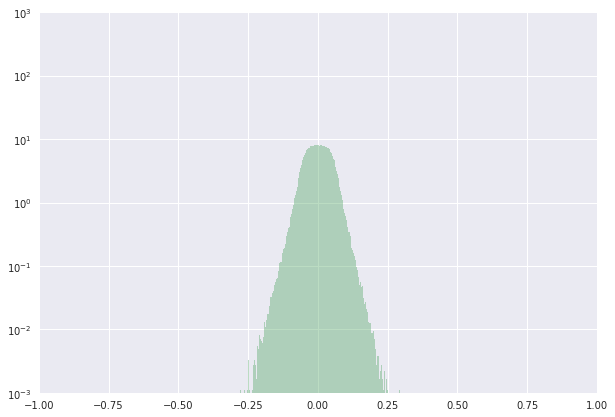

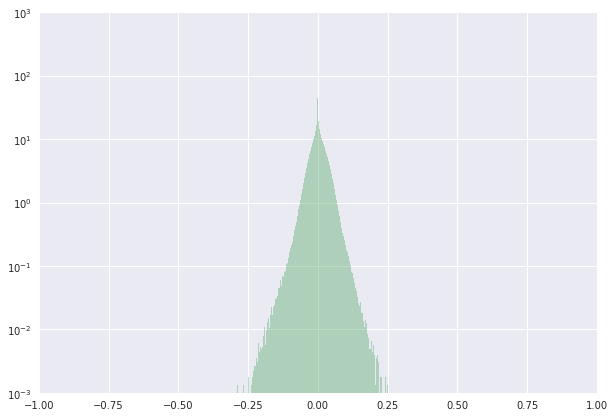

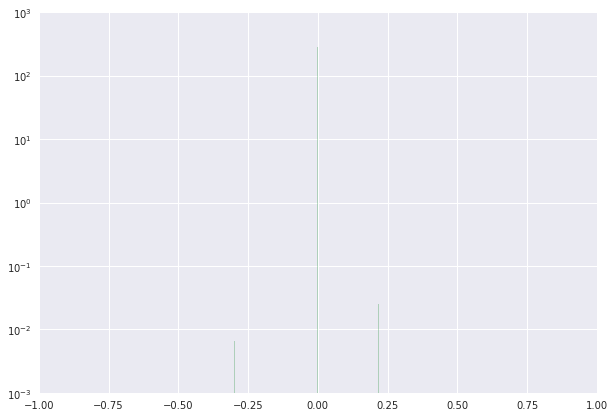

In [12]:
from helper_functions import save_histogram
save_histogram(pre_trained_model.get_weights(), save="Figures/reference")
save_histogram(weights_retrain, save="Figures/retrain")
save_histogram(weights_compressed, save="Figures/Post-Processing")

### Resultant Images and Discussions

|Weight distribution before retraining | Weight distribution after retraining|  Weight distribution after post-processing  
:-------------------------:|:-------------------------:|:------------:|:-------------------------:
histogram|![](./Figures/reference.png)|<img src="./Figures/retrain.png"/>| ![](./Figures/Post-Processing.png)
log-scaled histogram|![](./Figures/reference_log.png)|<img src="./Figures/retrain_log.png"/>| ![](./Figures/Post-Processing_log.png)

The histograms above supports the claims of the paper. We have shown the results for the histograms and log-scaled histograms. Here, the difference between the weight distributions before and after retraining is evident from the first two columns. Similarly, in the third column i.e. after performing Post-Processing, we can see that the non-zero weights are much less as compared to the original model. We also calculate the percentage of non-zero weights and it's only 10% of the orignal number of components which demonstrates the compression of neural network to a good extent. We are also running our optimizer and train the network for 50 epochs, it takes a bit of time because of large number of parameters. 
All the images attached here can be found in the Figures Folder of the submission. 

### References

[1] Karen Ullrich, Edward Meeds, and Max Welling. Soft Weight-Sharing for Neural Network Compression 2017. eprint:arXiv:1702.04008. url: https://arxiv.org/abs/1702.04008

[2] [Keras Tutorial on CNNs](https://github.com/fchollet/keras/blob/master/examples/mnist_cnn.py)

[3] Multiple codes from Keras.io - https://keras.io/

[4] Tutorials by Karen Ullrich